In [2]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [3]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 1

In [4]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [5]:
def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [6]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 0.1, 1000, 0.05)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 1000: PDE Error: 0.015401720896; False Transient Error: 0.015386857771; Iterations: 68; CG Error: 0.000000000097
Episode 1000: PDE Error: 0.031136371363; False Transient Error: 0.025237634201; Iterations: 69; CG Error: 0.000000000097
Episode 1000: PDE Error: 0.013157082872; False Transient Error: 0.013119165212; Iterations: 68; CG Error: 0.000000000083
Episode 1000: PDE Error: 0.027732248593; False Transient Error: 0.024183334436; Iterations: 69; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.029425962060; False Transient Error: 0.024727782748; Iterations: 69; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.013871702324; False Transient Error: 0.013858438177; Iterations: 68; CG Error: 0.000000000090
Episode 1000: PDE Error: 0.013384102046; False Transient Error: 0.013346493908; Iterations: 67; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.013705965259; False Transient Error: 0.013668803283; Iterations: 67; CG Error: 0.000000000081
Episode 1000: PDE Error: 0.01421

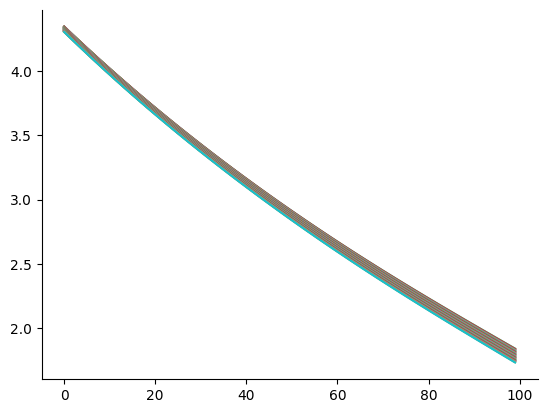

In [7]:
plt.plot(ϕ_list[0])
plt.show()

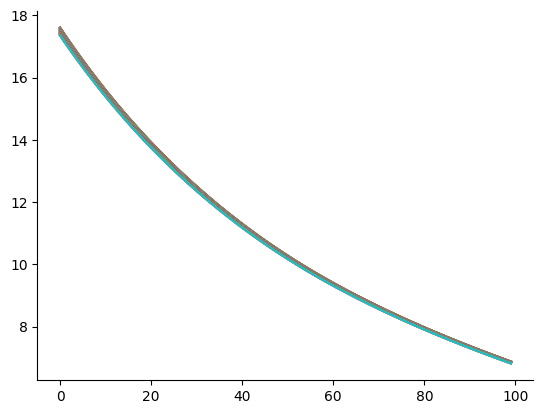

In [8]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [30]:
np.save(f"v_list_{λ}", ϕ_list)
np.save(f"e_list_{λ}", ems_list)

In [9]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.1
max_iter = 2000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.511978728123	 rhs error: 0.507258695489
Episode: 2	 lhs error: 0.507839314501	 rhs error: 0.503843217092
Episode: 3	 lhs error: 0.494585855112	 rhs error: 0.492017465505
Episode: 4	 lhs error: 0.477434878656	 rhs error: 0.475843482611
Episode: 5	 lhs error: 0.458084005425	 rhs error: 0.457030857820
Episode: 6	 lhs error: 0.437219288558	 rhs error: 0.436558116175
Episode: 7	 lhs error: 0.415416978590	 rhs error: 0.415095936738
Episode: 8	 lhs error: 0.393165488278	 rhs error: 0.393135848000
Episode: 9	 lhs error: 0.370869869249	 rhs error: 0.371047966786
Episode: 10	 lhs error: 0.348816718808	 rhs error: 0.349113813409
Episode: 11	 lhs error: 0.326858561733	 rhs error: 0.327574989897
Episode: 12	 lhs error: 0.306382120943	 rhs error: 0.306573564133
Episode: 13	 lhs error: 0.285681627618	 rhs error: 0.286215432371
Episode: 14	 lhs error: 0.266318051915	 rhs error: 0.266693529202
Episode: 15	 lhs error: 0.247314999803	 rhs error: 0.247948036982
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.036113052965	 rhs error: 0.093624864315
Episode: 126	 lhs error: 0.035736235440	 rhs error: 0.093657620286
Episode: 127	 lhs error: 0.035707854621	 rhs error: 0.093621903774
Episode: 128	 lhs error: 0.035436932512	 rhs error: 0.093599313743
Episode: 129	 lhs error: 0.035141023691	 rhs error: 0.093615352510
Episode: 130	 lhs error: 0.034984512184	 rhs error: 0.093597345020
Episode: 131	 lhs error: 0.034830706922	 rhs error: 0.093592266097
Episode: 132	 lhs error: 0.034680998220	 rhs error: 0.093551497031
Episode: 133	 lhs error: 0.034612917329	 rhs error: 0.093507547590
Episode: 134	 lhs error: 0.034555950400	 rhs error: 0.093462332648
Episode: 135	 lhs error: 0.034404245185	 rhs error: 0.093423829617
Episode: 136	 lhs error: 0.034356523323	 rhs error: 0.093371260622
Episode: 137	 lhs error: 0.034256718303	 rhs error: 0.093320203010
Episode: 138	 lhs error: 0.034140773035	 rhs error: 0.093272025067
Episode: 139	 lhs error: 0.034062418246	 rhs error: 0.09321058

Episode: 249	 lhs error: 0.024518909347	 rhs error: 0.084711813236
Episode: 250	 lhs error: 0.024353320135	 rhs error: 0.084426253003
Episode: 251	 lhs error: 0.024314494494	 rhs error: 0.084131620278
Episode: 252	 lhs error: 0.024172851463	 rhs error: 0.083833012299
Episode: 253	 lhs error: 0.024124808685	 rhs error: 0.083528769438
Episode: 254	 lhs error: 0.023985253524	 rhs error: 0.083222247506
Episode: 255	 lhs error: 0.023940718297	 rhs error: 0.082908682110
Episode: 256	 lhs error: 0.023885553277	 rhs error: 0.082594605702
Episode: 257	 lhs error: 0.023731215425	 rhs error: 0.082281314754
Episode: 258	 lhs error: 0.023668785559	 rhs error: 0.081969704134
Episode: 259	 lhs error: 0.023645863592	 rhs error: 0.081639169222
Episode: 260	 lhs error: 0.023606714340	 rhs error: 0.081314321753
Episode: 261	 lhs error: 0.023572928813	 rhs error: 0.081004516142
Episode: 262	 lhs error: 0.023566640820	 rhs error: 0.080654972944
Episode: 263	 lhs error: 0.023541458535	 rhs error: 0.08031805

Episode: 373	 lhs error: 0.018701261394	 rhs error: 0.048325736573
Episode: 374	 lhs error: 0.018638138925	 rhs error: 0.048025529033
Episode: 375	 lhs error: 0.018592482247	 rhs error: 0.047723715748
Episode: 376	 lhs error: 0.018539714245	 rhs error: 0.047422359415
Episode: 377	 lhs error: 0.018486335799	 rhs error: 0.047120560198
Episode: 378	 lhs error: 0.018434173884	 rhs error: 0.046818570633
Episode: 379	 lhs error: 0.018380217078	 rhs error: 0.046516504874
Episode: 380	 lhs error: 0.018326170450	 rhs error: 0.046214300739
Episode: 381	 lhs error: 0.018271378325	 rhs error: 0.045912057963
Episode: 382	 lhs error: 0.018216003894	 rhs error: 0.045609801169
Episode: 383	 lhs error: 0.018183694333	 rhs error: 0.045307582037
Episode: 384	 lhs error: 0.018164391356	 rhs error: 0.045005451325
Episode: 385	 lhs error: 0.018144621855	 rhs error: 0.044703456157
Episode: 386	 lhs error: 0.018124393648	 rhs error: 0.044401646888
Episode: 387	 lhs error: 0.018103687559	 rhs error: 0.04410007

Episode: 497	 lhs error: 0.014849775576	 rhs error: 0.023541294241
Episode: 498	 lhs error: 0.014830602019	 rhs error: 0.023396278951
Episode: 499	 lhs error: 0.014811599184	 rhs error: 0.023250120768
Episode: 500	 lhs error: 0.014792130962	 rhs error: 0.023103086485
Episode: 501	 lhs error: 0.014771863740	 rhs error: 0.022954979203
Episode: 502	 lhs error: 0.014751815724	 rhs error: 0.022806151416
Episode: 503	 lhs error: 0.014731172272	 rhs error: 0.022656306464
Episode: 504	 lhs error: 0.014710141777	 rhs error: 0.022505869666
Episode: 505	 lhs error: 0.014688848171	 rhs error: 0.022354246486
Episode: 506	 lhs error: 0.014667160004	 rhs error: 0.022202249704
Episode: 507	 lhs error: 0.014644887910	 rhs error: 0.022072806182
Episode: 508	 lhs error: 0.014622711082	 rhs error: 0.022032833470
Episode: 509	 lhs error: 0.014599847186	 rhs error: 0.021993593336
Episode: 510	 lhs error: 0.014576599904	 rhs error: 0.021954992672
Episode: 511	 lhs error: 0.014553208200	 rhs error: 0.02191701

Episode: 621	 lhs error: 0.012139530002	 rhs error: 0.021268533191
Episode: 622	 lhs error: 0.012114948762	 rhs error: 0.021267332673
Episode: 623	 lhs error: 0.012088847219	 rhs error: 0.021265754332
Episode: 624	 lhs error: 0.012063912961	 rhs error: 0.021263485036
Episode: 625	 lhs error: 0.012039619713	 rhs error: 0.021261044236
Episode: 626	 lhs error: 0.012077069266	 rhs error: 0.021257436225
Episode: 627	 lhs error: 0.012003934818	 rhs error: 0.021271982246
Episode: 628	 lhs error: 0.011973690202	 rhs error: 0.021274514313
Episode: 629	 lhs error: 0.011957404971	 rhs error: 0.021274833690
Episode: 630	 lhs error: 0.011943764410	 rhs error: 0.021273549611
Episode: 631	 lhs error: 0.011928806187	 rhs error: 0.021271859015
Episode: 632	 lhs error: 0.011968421634	 rhs error: 0.021268061636
Episode: 633	 lhs error: 0.011914402669	 rhs error: 0.021281859756
Episode: 634	 lhs error: 0.011896031293	 rhs error: 0.021283878594
Episode: 635	 lhs error: 0.011878446509	 rhs error: 0.02128406

Episode: 745	 lhs error: 0.010099174796	 rhs error: 0.021330739864
Episode: 746	 lhs error: 0.010079267800	 rhs error: 0.021328973087
Episode: 747	 lhs error: 0.010060840975	 rhs error: 0.021326092046
Episode: 748	 lhs error: 0.010041697489	 rhs error: 0.021323005154
Episode: 749	 lhs error: 0.010056528945	 rhs error: 0.021318301671
Episode: 750	 lhs error: 0.010012266098	 rhs error: 0.021328837886
Episode: 751	 lhs error: 0.009991488017	 rhs error: 0.021328698088
Episode: 752	 lhs error: 0.009979265963	 rhs error: 0.021326886927
Episode: 753	 lhs error: 0.009968319170	 rhs error: 0.021323968979
Episode: 754	 lhs error: 0.009983322783	 rhs error: 0.021319742512
Episode: 755	 lhs error: 0.009952523704	 rhs error: 0.021329890730
Episode: 756	 lhs error: 0.009938031032	 rhs error: 0.021329787573
Episode: 757	 lhs error: 0.009925132591	 rhs error: 0.021327755371
Episode: 758	 lhs error: 0.009913365960	 rhs error: 0.021324775727
Episode: 759	 lhs error: 0.009900915145	 rhs error: 0.02132166

Episode: 869	 lhs error: 0.008507431932	 rhs error: 0.021290492844
Episode: 870	 lhs error: 0.008504621244	 rhs error: 0.021286820498
Episode: 871	 lhs error: 0.008489566538	 rhs error: 0.021295846233
Episode: 872	 lhs error: 0.008477878666	 rhs error: 0.021295597148
Episode: 873	 lhs error: 0.008466947172	 rhs error: 0.021293656398
Episode: 874	 lhs error: 0.008456452183	 rhs error: 0.021291000597
Episode: 875	 lhs error: 0.008445623750	 rhs error: 0.021288380484
Episode: 876	 lhs error: 0.008441875975	 rhs error: 0.021284347718
Episode: 877	 lhs error: 0.008426143094	 rhs error: 0.021293449967
Episode: 878	 lhs error: 0.008413776940	 rhs error: 0.021293067632
Episode: 879	 lhs error: 0.008401904095	 rhs error: 0.021291318587
Episode: 880	 lhs error: 0.008390512046	 rhs error: 0.021288731612
Episode: 881	 lhs error: 0.008385744196	 rhs error: 0.021285141826
Episode: 882	 lhs error: 0.008369349788	 rhs error: 0.021294055883
Episode: 883	 lhs error: 0.008356096311	 rhs error: 0.02129382

Episode: 993	 lhs error: 0.007217705159	 rhs error: 0.021279120362
Episode: 994	 lhs error: 0.007210666645	 rhs error: 0.021277356299
Episode: 995	 lhs error: 0.007203448153	 rhs error: 0.021275203208
Episode: 996	 lhs error: 0.007196018525	 rhs error: 0.021273027665
Episode: 997	 lhs error: 0.007177596841	 rhs error: 0.021270054611
Episode: 998	 lhs error: 0.007179167081	 rhs error: 0.021278907614
Episode: 999	 lhs error: 0.007171641046	 rhs error: 0.021279348240
Episode: 1000	 lhs error: 0.007163999566	 rhs error: 0.021278368250
Episode: 1001	 lhs error: 0.007155941611	 rhs error: 0.021276603373
Episode: 1002	 lhs error: 0.007148068146	 rhs error: 0.021274935557
Episode: 1003	 lhs error: 0.007128521519	 rhs error: 0.021271944239
Episode: 1004	 lhs error: 0.007129976571	 rhs error: 0.021280567915
Episode: 1005	 lhs error: 0.007121663106	 rhs error: 0.021280748328
Episode: 1006	 lhs error: 0.007113314754	 rhs error: 0.021279757804
Episode: 1007	 lhs error: 0.007104600584	 rhs error: 0.

Episode: 1117	 lhs error: 0.006182428415	 rhs error: 0.021276879514
Episode: 1118	 lhs error: 0.006176386602	 rhs error: 0.021276043801
Episode: 1119	 lhs error: 0.006169684687	 rhs error: 0.021274675148
Episode: 1120	 lhs error: 0.006162465497	 rhs error: 0.021273270997
Episode: 1121	 lhs error: 0.006155529333	 rhs error: 0.021272095268
Episode: 1122	 lhs error: 0.006148532243	 rhs error: 0.021270921596
Episode: 1123	 lhs error: 0.006141346174	 rhs error: 0.021269778000
Episode: 1124	 lhs error: 0.006107477258	 rhs error: 0.021267836026
Episode: 1125	 lhs error: 0.006122086750	 rhs error: 0.021276875438
Episode: 1126	 lhs error: 0.006116203021	 rhs error: 0.021278290116
Episode: 1127	 lhs error: 0.006109677621	 rhs error: 0.021278256775
Episode: 1128	 lhs error: 0.006101681667	 rhs error: 0.021277340444
Episode: 1129	 lhs error: 0.006094636450	 rhs error: 0.021276559826
Episode: 1130	 lhs error: 0.006086913936	 rhs error: 0.021275230582
Episode: 1131	 lhs error: 0.006078660998	 rhs er

Episode: 1241	 lhs error: 0.005313198570	 rhs error: 0.021277361624
Episode: 1242	 lhs error: 0.005305966223	 rhs error: 0.021276966034
Episode: 1243	 lhs error: 0.005299476760	 rhs error: 0.021276566736
Episode: 1244	 lhs error: 0.005294124119	 rhs error: 0.021276182673
Episode: 1245	 lhs error: 0.005288716052	 rhs error: 0.021275820331
Episode: 1246	 lhs error: 0.005283236107	 rhs error: 0.021275470598
Episode: 1247	 lhs error: 0.005277665104	 rhs error: 0.021275132072
Episode: 1248	 lhs error: 0.005272028519	 rhs error: 0.021274810215
Episode: 1249	 lhs error: 0.005266315728	 rhs error: 0.021274499689
Episode: 1250	 lhs error: 0.005260526217	 rhs error: 0.021274200838
Episode: 1251	 lhs error: 0.005254659224	 rhs error: 0.021273913629
Episode: 1252	 lhs error: 0.005248720617	 rhs error: 0.021273638271
Episode: 1253	 lhs error: 0.005242703103	 rhs error: 0.021273372740
Episode: 1254	 lhs error: 0.005236612223	 rhs error: 0.021273118155
Episode: 1255	 lhs error: 0.005188704035	 rhs er

Episode: 1365	 lhs error: 0.004587790311	 rhs error: 0.021286213190
Episode: 1366	 lhs error: 0.004582747964	 rhs error: 0.021286425384
Episode: 1367	 lhs error: 0.004577639458	 rhs error: 0.021286643687
Episode: 1368	 lhs error: 0.004572474410	 rhs error: 0.021286869031
Episode: 1369	 lhs error: 0.004567243020	 rhs error: 0.021287099288
Episode: 1370	 lhs error: 0.004561946920	 rhs error: 0.021287335933
Episode: 1371	 lhs error: 0.004556589921	 rhs error: 0.021287579341
Episode: 1372	 lhs error: 0.004551171721	 rhs error: 0.021287828770
Episode: 1373	 lhs error: 0.004545687735	 rhs error: 0.021288083920
Episode: 1374	 lhs error: 0.004540140060	 rhs error: 0.021288345384
Episode: 1375	 lhs error: 0.004534532987	 rhs error: 0.021288613429
Episode: 1376	 lhs error: 0.004528861465	 rhs error: 0.021288886938
Episode: 1377	 lhs error: 0.004523125519	 rhs error: 0.021289166239
Episode: 1378	 lhs error: 0.004517326713	 rhs error: 0.021289451866
Episode: 1379	 lhs error: 0.004511465863	 rhs er

Episode: 1489	 lhs error: 0.003958287066	 rhs error: 0.021338092794
Episode: 1490	 lhs error: 0.003953950395	 rhs error: 0.021338521131
Episode: 1491	 lhs error: 0.003949554384	 rhs error: 0.021338948757
Episode: 1492	 lhs error: 0.003945111518	 rhs error: 0.021339377770
Episode: 1493	 lhs error: 0.003940617872	 rhs error: 0.021339806945
Episode: 1494	 lhs error: 0.003936066953	 rhs error: 0.021340236143
Episode: 1495	 lhs error: 0.003931470099	 rhs error: 0.021340666942
Episode: 1496	 lhs error: 0.003926817626	 rhs error: 0.021341097786
Episode: 1497	 lhs error: 0.003922111723	 rhs error: 0.021341529634
Episode: 1498	 lhs error: 0.003917356934	 rhs error: 0.021341962963
Episode: 1499	 lhs error: 0.003912545105	 rhs error: 0.021342396657
Episode: 1500	 lhs error: 0.003907688505	 rhs error: 0.021342832260
Episode: 1501	 lhs error: 0.003902770084	 rhs error: 0.021343267808
Episode: 1502	 lhs error: 0.003897803476	 rhs error: 0.021343705825
Episode: 1503	 lhs error: 0.003892787066	 rhs er

Episode: 1613	 lhs error: 0.003030243694	 rhs error: 0.021400528613
Episode: 1614	 lhs error: 0.003020000594	 rhs error: 0.021400929929
Episode: 1615	 lhs error: 0.003009738289	 rhs error: 0.021401317659
Episode: 1616	 lhs error: 0.002999439614	 rhs error: 0.021401689207
Episode: 1617	 lhs error: 0.002989122978	 rhs error: 0.021402046924
Episode: 1618	 lhs error: 0.002978781867	 rhs error: 0.021402388038
Episode: 1619	 lhs error: 0.002968420161	 rhs error: 0.021402711692
Episode: 1620	 lhs error: 0.002958027646	 rhs error: 0.021403016484
Episode: 1621	 lhs error: 0.002947626266	 rhs error: 0.021403304294
Episode: 1622	 lhs error: 0.002937193773	 rhs error: 0.021403570271
Episode: 1623	 lhs error: 0.002926750579	 rhs error: 0.021403816869
Episode: 1624	 lhs error: 0.002916282710	 rhs error: 0.021404040501
Episode: 1625	 lhs error: 0.002905804105	 rhs error: 0.021404242231
Episode: 1626	 lhs error: 0.002895300242	 rhs error: 0.021404418907
Episode: 1627	 lhs error: 0.002884790893	 rhs er

Episode: 1737	 lhs error: 0.001715470678	 rhs error: 0.021243215761
Episode: 1738	 lhs error: 0.001708312511	 rhs error: 0.021239965373
Episode: 1739	 lhs error: 0.001698790349	 rhs error: 0.021236105607
Episode: 1740	 lhs error: 0.001688179394	 rhs error: 0.021232255825
Episode: 1741	 lhs error: 0.001599707484	 rhs error: 0.021227793998
Episode: 1742	 lhs error: 0.001646635700	 rhs error: 0.021236286193
Episode: 1743	 lhs error: 0.001644722402	 rhs error: 0.021237395424
Episode: 1744	 lhs error: 0.001640580442	 rhs error: 0.021236103640
Episode: 1745	 lhs error: 0.001631631318	 rhs error: 0.021233230838
Episode: 1746	 lhs error: 0.001624926699	 rhs error: 0.021230063420
Episode: 1747	 lhs error: 0.001537377023	 rhs error: 0.021225358710
Episode: 1748	 lhs error: 0.001585108415	 rhs error: 0.021233091681
Episode: 1749	 lhs error: 0.001581772051	 rhs error: 0.021233672831
Episode: 1750	 lhs error: 0.001577591516	 rhs error: 0.021232331000
Episode: 1751	 lhs error: 0.001569086228	 rhs er

Episode: 1861	 lhs error: 0.000672065072	 rhs error: 0.021199127099
Episode: 1862	 lhs error: 0.000666443904	 rhs error: 0.021198296326
Episode: 1863	 lhs error: 0.001186680173	 rhs error: 0.021196720535
Episode: 1864	 lhs error: 0.000638825132	 rhs error: 0.021206581155
Episode: 1865	 lhs error: 0.000640728443	 rhs error: 0.021208930369
Episode: 1866	 lhs error: 0.000639857827	 rhs error: 0.021209351846
Episode: 1867	 lhs error: 0.000634170248	 rhs error: 0.021208610404
Episode: 1868	 lhs error: 0.000631004763	 rhs error: 0.021207886552
Episode: 1869	 lhs error: 0.000625768494	 rhs error: 0.021206660401
Episode: 1870	 lhs error: 0.000619362868	 rhs error: 0.021205504891
Episode: 1871	 lhs error: 0.000614189609	 rhs error: 0.021204675711
Episode: 1872	 lhs error: 0.000609094672	 rhs error: 0.021203910397
Episode: 1873	 lhs error: 0.000603790166	 rhs error: 0.021203213501
Episode: 1874	 lhs error: 0.000598576327	 rhs error: 0.021202610083
Episode: 1875	 lhs error: 0.000593588453	 rhs er

Episode: 1985	 lhs error: 0.000206316984	 rhs error: 0.021261443228
Episode: 1986	 lhs error: 0.000204430225	 rhs error: 0.021260525978
Episode: 1987	 lhs error: 0.000202886683	 rhs error: 0.021259679507
Episode: 1988	 lhs error: 0.001193179967	 rhs error: 0.021258042560
Episode: 1989	 lhs error: 0.000190823418	 rhs error: 0.021266363055
Episode: 1990	 lhs error: 0.000187085523	 rhs error: 0.021269713229
Episode: 1991	 lhs error: 0.000190146750	 rhs error: 0.021270895911
Episode: 1992	 lhs error: 0.000189527377	 rhs error: 0.021270744550
Episode: 1993	 lhs error: 0.000197086310	 rhs error: 0.021270203865
Episode: 1994	 lhs error: 0.000205390861	 rhs error: 0.021269160256
Episode: 1995	 lhs error: 0.000191864167	 rhs error: 0.021267927632
Episode: 1996	 lhs error: 0.001173196553	 rhs error: 0.021265924870
Episode: 1997	 lhs error: 0.000178134312	 rhs error: 0.021273845781
Episode: 1998	 lhs error: 0.000172120182	 rhs error: 0.021276943348
Episode: 1999	 lhs error: 0.000185597873	 rhs er

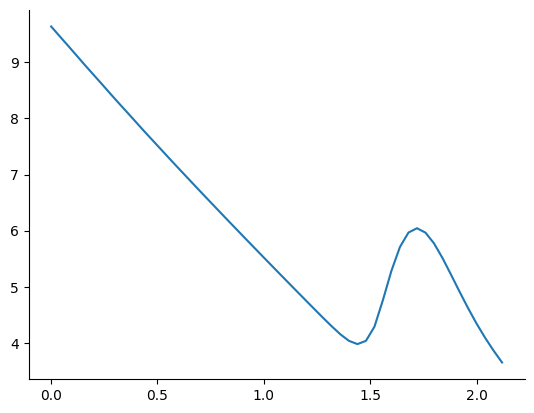

In [10]:
plt.plot(y1_grid_cap, ems[:,-1])
plt.show()

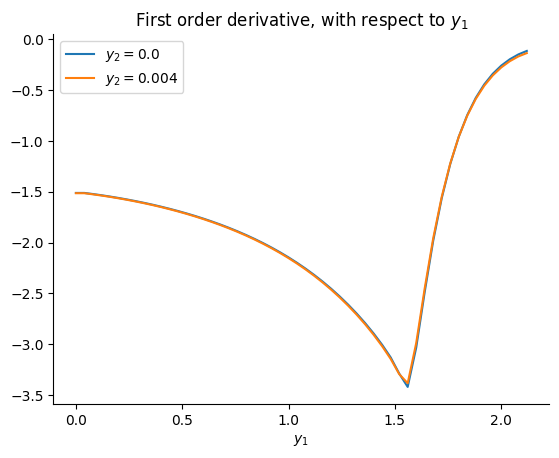

In [11]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

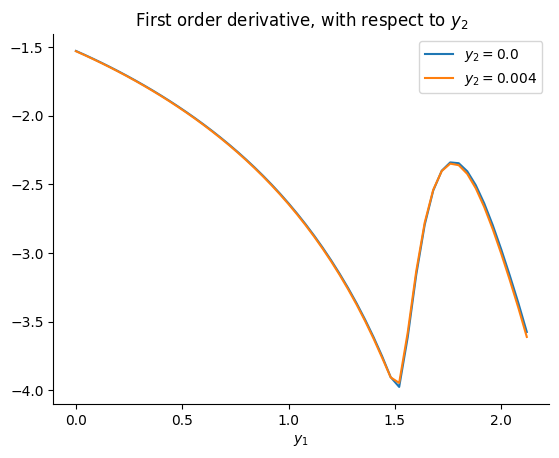

In [12]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

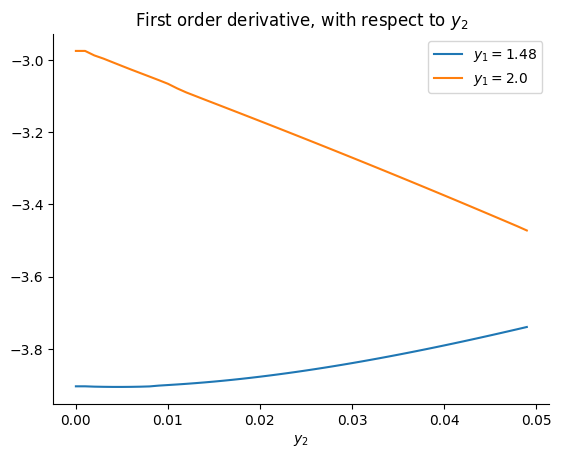

In [13]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

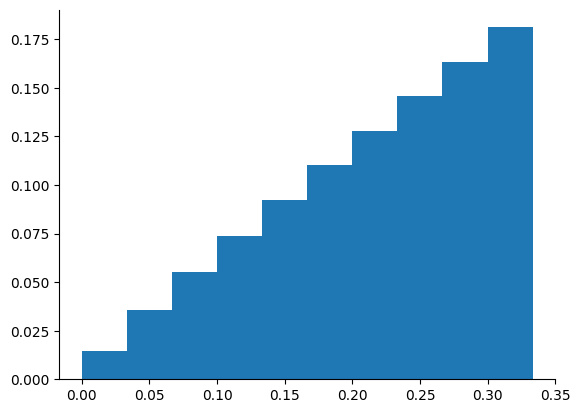

In [14]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

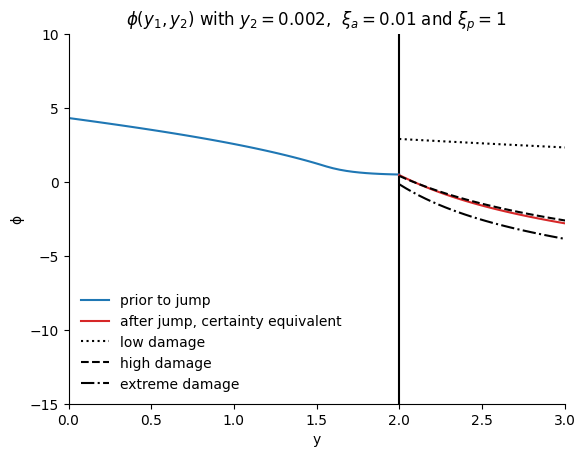

In [15]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

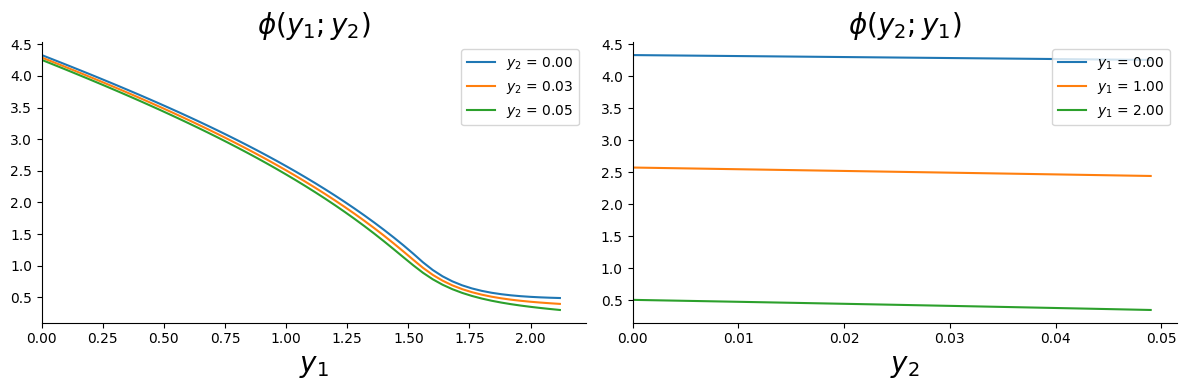

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

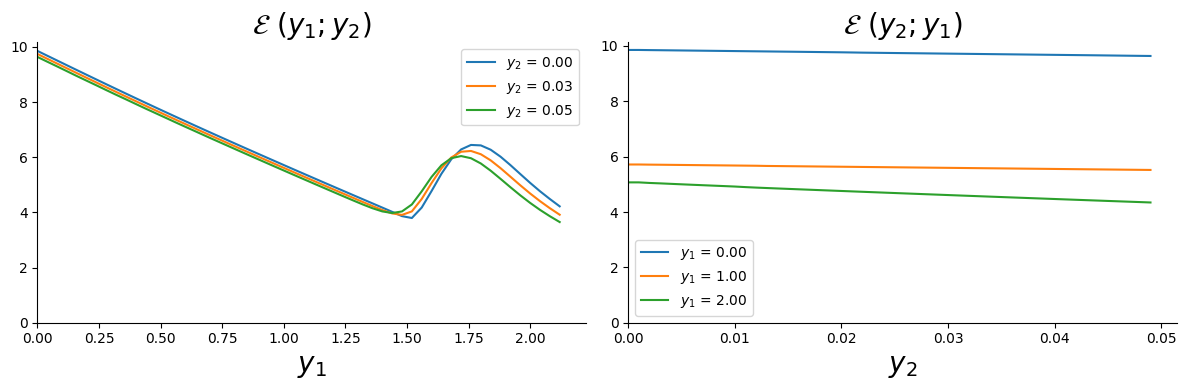

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [18]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [19]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ) * y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [20]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [21]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [23]:
ems_1state.shape, 

((20, 501),)

In [24]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

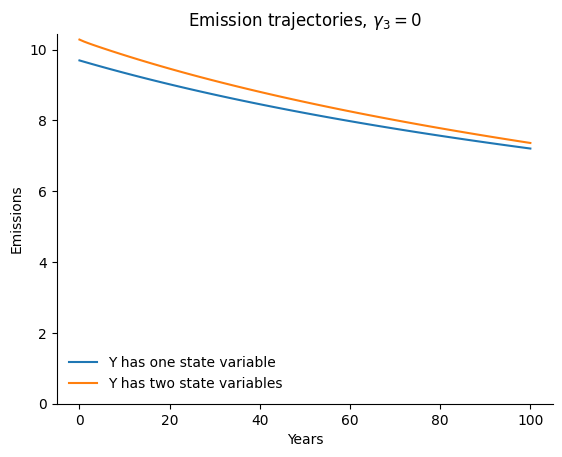

In [25]:
plt.title("Emission trajectories, $γ_3 = 0$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2")
plt.show()

In [26]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=100
                                                 )

In [28]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open(f"simul_{λ}", "wb"))

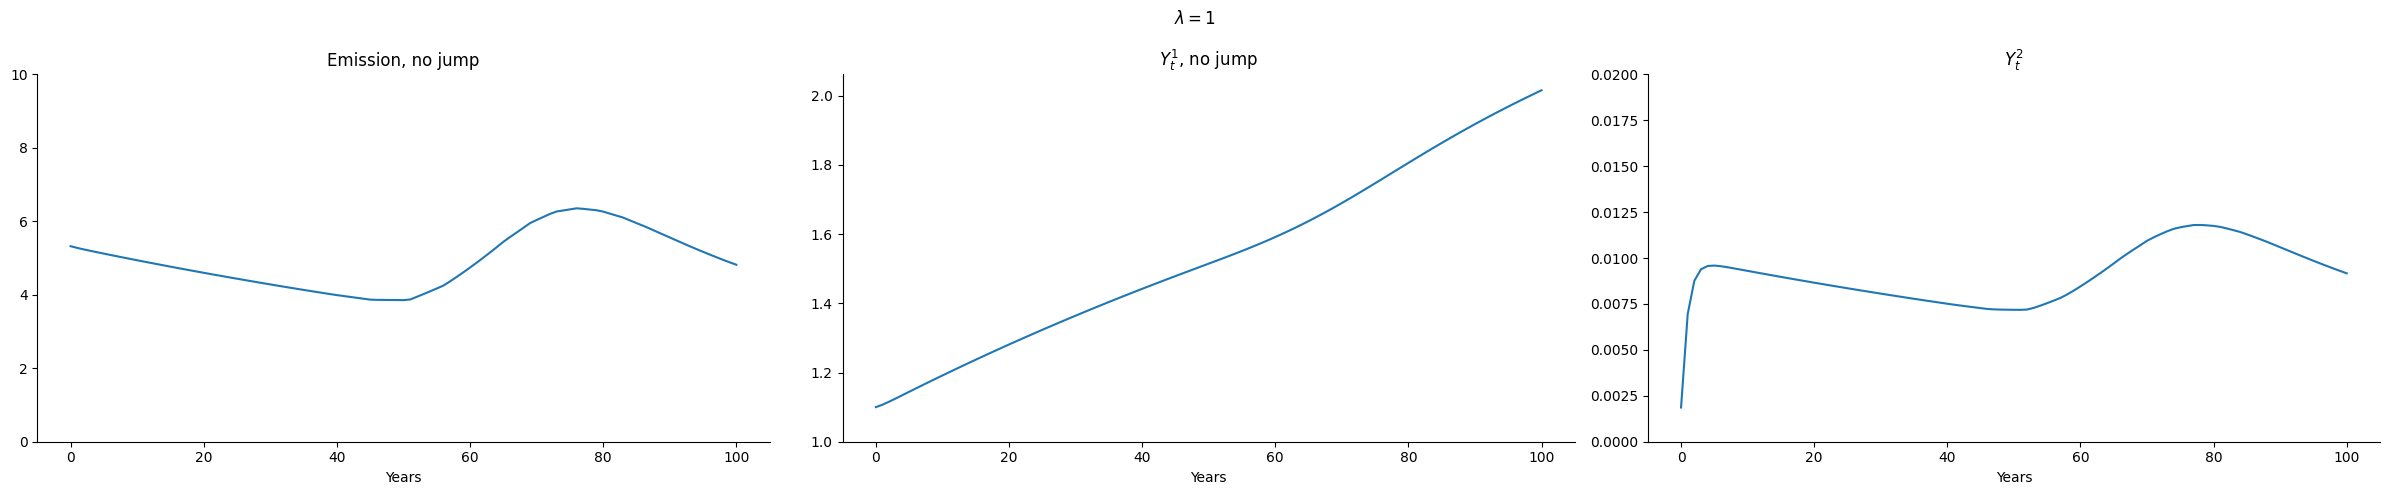

In [27]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0, 10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
plt.savefig(f"e_y1_y2_{λ}")
plt.show()

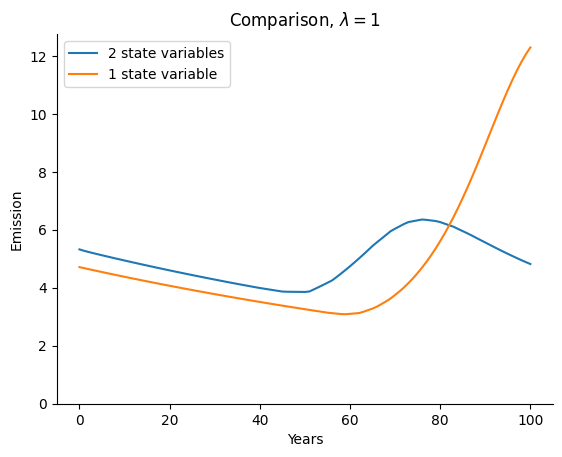

In [64]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [65]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [66]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [67]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=100 + 1)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

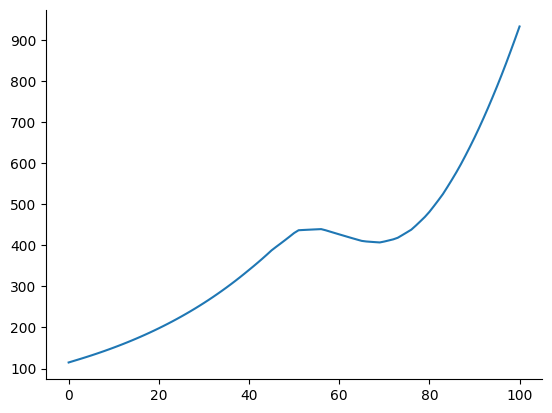

In [68]:
plt.plot(scc)
plt.show()

In [69]:
np.save(f"scct_{λ}", scc)

In [75]:
scc_1 = np.load("scct_1.npy")
scc_2 = np.load("scct_2.npy")
scc_5 = np.load("scct_5.npy")

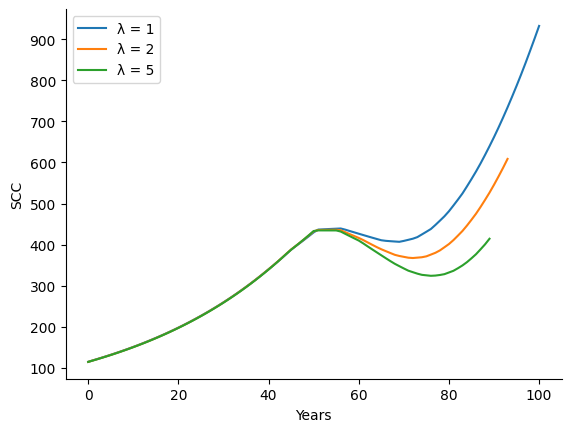

In [77]:
plt.plot(scc_1, label="λ = 1")
plt.plot(scc_2, label="λ = 2")
plt.plot(scc_5, label = "λ = 5")
plt.legend()
plt.xlabel("Years")
plt.ylabel("SCC")
plt.savefig("SCC_t")
plt.show()